# Part 5 
#### Plot a graph of training and validation error with respect to depth of decision tree. Also plot the training and validation error with respect to number of nodes in the decision tree

In [1]:
import pandas as pd
import numpy as num
import random
import math
import pprint

In [2]:
def train_test_set(data,precentage):
    indices=data.index.tolist()
    test_size=(int)(precentage*len(data))
    test_set_indices=random.sample(population=indices,k=test_size)
    #print test_size
    #print len(data)
    test_set=data.loc[test_set_indices]
    #print test_set_indices
    train_set=data.drop(test_set_indices)
    return train_set,test_set
list_categorial_attribute=['Work_accident','promotion_last_5years','sales','salary']
list_numeric_attribute=['satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company'
]
dic_avg_numeric={}

#### Reading and Dividing data in Training and Vaildation data 

In [3]:
data=pd.read_csv("train.csv")
#data.head()
# train_data ,test_data = train_test_set(data ,0.2)
train_data=data.sample(frac=0.8,random_state=200)
test_data=data.drop(train_data.index)

#### is_pure fuction 
Tests wheather only one type data is left or not

In [4]:
def is_pure(data):
    current=data['left']
    if len(set(current))==1:
        return True 
    else: 
        return False
is_pure(train_data)

False

#### calc _entropy function 
Calculates the entropy of given Data  

In [5]:
def calc_entropy(data):
    current=data['left'].tolist()
    if is_pure(data):
        return 0
    else:
        num_one=current.count(1)
        p=num_one/float(len(data.index))
#         p=(num_one/float(len(current)))
        entropy= ((p*math.log(p,2)) + ((1-p)*math.log(1-p,2)))*-1
#         print entropy
        return entropy
        
calc_entropy(train_data)


0.7986105014037017

#### calc_information function
calculates the information in given data with respect each and every atttributes provided

In [6]:
def calc_information(data,attribute):
    current=set(data[attribute])
    information=0
    for cur in current:
        current_data=data[data[attribute]==cur]
        current_entropy=calc_entropy(current_data)*(len(current_data.index)/float(len(data.index)))
        information=information+current_entropy
    return information
calc_information(train_data,'sales')    

0.7931530920122911

#### calc_information_gain function
 Calculates Information Gain of attribute on the given data

In [7]:
def calc_inforamtion_gain(data,attribute):
    return calc_entropy(data)-calc_information(data,attribute)
calc_inforamtion_gain(train_data,'sales')

0.005457409391410595

#### best_information_gain function 
Find best information gain attributes of from all attributes of present in the list_categorial_attribute

In [8]:
def best_information_gain(data,list_categorial_attribute):
    dict_categorial_attribute={}
    flag=0
    min_v=0
    min_at=''
    for attr in list_categorial_attribute:
        if flag==0:
            min_v=calc_inforamtion_gain(data,attr)
            min_at=attr
            flag=1
        elif min_v<calc_inforamtion_gain(data,attr):
            min_v=min_v=calc_inforamtion_gain(data,attr)
            min_at=attr
    return min_at
best_information_gain(train_data,list_categorial_attribute)

'salary'

#### covert_numeric_to_categorical function
Fucntion converts the numeric data to categorical data by assigning labels to the in place of numeric values of the attributes.
First data is sorted according to the numeric value attribute and the all unique numeric values present in the numerical value attribute is obtained then for all the unique value we find out what is maximum number of time occuring in 'left' attribute of data and that value is assign to that unique value.And then data is accessed is sequential and where the value assigned to numeric value changes the average of numerical value is taken and value less that value is given one label and value greater than that avgerage falls under other label


In [9]:
def convert_numeric_to_categorical(data,attribute):
    data.sort_values(by=[attribute],inplace=True)
#     print data
    dic={}
    li=data[attribute].unique().tolist()
    for l in li :
        temp=data[data[attribute]==l]
        dic[l]=num.unique(temp['left'])[num.argmax(num.unique(temp['left'], return_counts = True)[1])]
#     print dic                                               
    flag=0
    avg_list=[]
    count=0
    for i in data.index :
        if flag==0:
            prev_elem=data.loc[i,attribute]
            prev_left=dic[prev_elem]
            flag=1
        elif prev_left!=dic[data.loc[i,attribute]]:
            avg_list.append((prev_elem+data.loc[i,attribute])/2.0)
            prev_elem=data.loc[i,attribute]
            prev_left=dic[prev_elem]
            count=count+1
#             print count
        else :
            prev_elem=data.loc[i,attribute]
            prev_left=dic[prev_elem]
#     print avg_list
    dic_avg_numeric[attribute]=avg_list
    label=0
    list_label=[]
    index_list=[]
    f=0
    for i in data.index :
        label=0
        index_list.append(i)
        f=0
        for j in avg_list:
            if data.loc[i,attribute]<=j:
                list_label.append(label)
                f=1
                break
            else :
                label=label+1
        if f==0:
            list_label.append(label)
#     print pd.Series(list_label)
    
#     print len(data)
#     print data.head()
    
    num_attribute=attribute+'_numeric'
    data[num_attribute]=pd.Series(list_label,index=index_list)
    
#     print data.head()
def label_prediction(data,attribute):
    avg_list=dic_avg_numeric[attribute]
    label=0
    list_label=[]
    index_list=[]
    f=0
    for i in data.index :
        label=0
        index_list.append(i)
        f=0
        for j in avg_list:
            if data.loc[i,attribute]<=j:
                list_label.append(label)
                f=1
                break
            else :
                label=label+1
        if f==0:
            list_label.append(label)
    num_attribute=attribute+'_numeric'
    data[num_attribute]=pd.Series(list_label,index=index_list)



for attr in list_numeric_attribute:
     convert_numeric_to_categorical(train_data,attr)
# convert_numeric_to_categorical(train_data,'satisfaction_level')
# print train_data

#### build_tree 
build_tree fuctions builds tree on the currrently present data in the form of dictionary of dictionary,while recurrsively calling itself again and agian and assigning attribute with best_gain_attribute as root of present tree untill one of following conditions is meet-
1. Data size become zero 
2. No Attributes is present in attribute_list 
3. All data left column value is same


In [10]:
def build_tree(table, prev_table, attribute_list, tree = None):
    if len(set(table['left'])) <= 1:
        return {'leaf' : table['left'].tolist()[0]}
    elif len(table) == 0:
        return {'leaf': num.unique(prev_table['left'])[num.argmax(num.unique(prev_table['left'], return_counts = True)[1])]}
    elif len(attribute_list) == 0:
        return {'leaf': num.unique(prev_table['left'])[num.argmax(num.unique(prev_table['left'], return_counts = True)[1])]}
    node = best_information_gain(table, attribute_list)
    attribute_list.remove(node)
    if tree is None:
        tree = {}
        tree[node] = {}
        tree['current_max']=num.unique(prev_table['left'])[num.argmax(num.unique(prev_table['left'], return_counts = True)[1])]
    for v in table[node].unique():
        mod_table = table.where(table[node] == v).dropna()
        tree[node][v] = build_tree(mod_table, table, attribute_list[:])
    return tree
list_final=[]
list_final=list_categorial_attribute[:]
for i in list_numeric_attribute:
    list_final.append(i+'_numeric')
    
tree = build_tree(train_data, train_data, list_final[:])
# pprint.pprint(tree)

#### predict_helper and predict fucntion :
Function predict_helper is called on whole validation_data and then predict fucntion is called on each row one by one and  tree build throung train data is used to predict the result of the given row 

In [11]:
def a_predict_helper(test_data , li , tree,depth):
    for i in test_data.index:
        a_predict(test_data.loc[i],li,tree,depth,0)
    return li
def a_predict(row,li,tree,depth,cur_depth):
    try:
        if tree.keys()[0]=='leaf':
            li.append(tree['leaf'])
        else:    
            t='0'
            if tree.keys()[0]=='current_max':
                t=tree.keys()[1]
            else:
                t=tree.keys()[0]
            value=row[t]
            if cur_depth==depth:
                li.append(tree['current_max'])
            else:    
                a_predict(row,li,tree[t][value],depth,cur_depth+1)
    except:
        li.append(0.0) 
for attr in list_numeric_attribute:
     label_prediction(test_data,attr)
pridected_value={}
for i in range(10):
    pridected_value[i]= a_predict_helper(test_data,[],tree,i)

#### calc_prefomance function
Calcalutes the preformance of the predict values from the tree at each depth produce through the build_tree with respect to it's actual value
And give Accuracy,Precision ,Recall & F1 for each depth

In [12]:
target_value = test_data['left'].tolist()
def calc_preformance(target_value,pridected_value):
    t_p=0
    f_p=0
    t_n=0
    f_n=0
    for i in range(len(target_value)):
        if target_value[i]==0 and target_value[i]==pridected_value[i]:
            t_n=t_n+1
        elif target_value[i]==1 and target_value[i]==pridected_value[i]:
            t_p=t_p+1
        elif pridected_value[i]==1 and target_value[i]==0:
            f_p=f_p+1
        elif pridected_value[i]==0 and target_value[i]==1:
            f_n=f_n+1

    accuracy=(t_n+t_p)/float(t_n+t_p+f_p+f_n)
    if t_p !=0  :
        precison=(t_p)/float(t_p+f_p)
        recall=(t_p)/float(t_p+f_n)
        a=1/precison
        b=1/recall
        f1_score=2/(a+b)
    else:
        precison=0
        recall=0
        a=0
        b=0
        f1_score=0
        
    print "ture positive",t_p
    print "false positive",f_p
    print "false negative",f_n
    print "ture negative",t_n
    
    print "Accuracy ",accuracy
    print "Precision ",precison
    print "Recall ",recall
    print "F1 Score",f1_score
    return 1-accuracy
list_accuracy_test=[]
list_depth=[]
for i in range(10):
    print i
    list_depth.append(i+1)
    list_accuracy_test.append(calc_preformance(target_value,pridected_value[i]))


0
ture positive 0
false positive 0
false negative 498
ture negative 1750
Accuracy  0.77846975089
Precision  0
Recall  0
F1 Score 0
1
ture positive 140
false positive 0
false negative 358
ture negative 1750
Accuracy  0.840747330961
Precision  1.0
Recall  0.281124497992
F1 Score 0.438871473354
2
ture positive 354
false positive 76
false negative 144
ture negative 1674
Accuracy  0.902135231317
Precision  0.823255813953
Recall  0.710843373494
F1 Score 0.762931034483
3
ture positive 450
false positive 72
false negative 48
ture negative 1678
Accuracy  0.946619217082
Precision  0.862068965517
Recall  0.903614457831
F1 Score 0.882352941176
4
ture positive 450
false positive 53
false negative 48
ture negative 1697
Accuracy  0.955071174377
Precision  0.894632206759
Recall  0.903614457831
F1 Score 0.899100899101
5
ture positive 453
false positive 56
false negative 45
ture negative 1694
Accuracy  0.955071174377
Precision  0.889980353635
Recall  0.909638554217
F1 Score 0.899702085402
6
ture positiv

#### Graph of validation error with respect to depth of your decision tree.

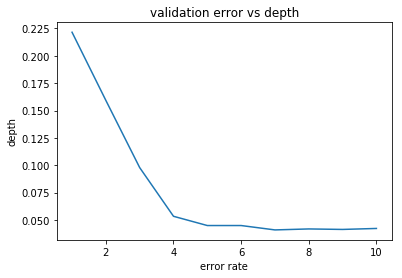

In [14]:
import matplotlib.pyplot as plt
plt.plot(list_depth,list_accuracy_test)
plt.title('validation error vs depth')
plt.xlabel('error rate')
plt.ylabel('depth')
plt.show()


In [15]:
pridected_value={}
target_value = train_data['left'].tolist()
for i in range(10):
    pridected_value[i]= a_predict_helper(train_data,[],tree,i)
#     print len(pridected_value[i])
list_accuracy_train=[]
list_depth=[]

for i in range(10):
#     print i
    list_depth.append(i+1)
    list_accuracy_train.append(calc_preformance(target_value, pridected_value[i]))


ture positive 0
false positive 0
false negative 2177
ture negative 6813
Accuracy  0.757842046719
Precision  0
Recall  0
F1 Score 0
ture positive 534
false positive 0
false negative 1643
ture negative 6813
Accuracy  0.81724137931
Precision  1.0
Recall  0.245291685806
F1 Score 0.393950571745
ture positive 1482
false positive 274
false negative 695
ture negative 6539
Accuracy  0.892213570634
Precision  0.843963553531
Recall  0.680753330271
F1 Score 0.753623188406
ture positive 1912
false positive 196
false negative 265
ture negative 6617
Accuracy  0.94872080089
Precision  0.907020872865
Recall  0.878272852549
F1 Score 0.892415402567
ture positive 1907
false positive 148
false negative 270
ture negative 6665
Accuracy  0.953503893215
Precision  0.92798053528
Recall  0.875976113918
F1 Score 0.901228733459
ture positive 1950
false positive 149
false negative 227
ture negative 6664
Accuracy  0.958175750834
Precision  0.929013816103
Recall  0.895728066146
F1 Score 0.912067352666
ture positive 1

#### Graph of training error with respect to depth of your decision tree.

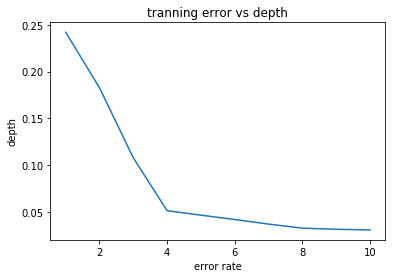

In [16]:
import matplotlib.pyplot as plt
plt.plot(list_depth,list_accuracy_train)
plt.title('tranning error vs depth')
plt.xlabel('error rate')
plt.ylabel('depth')
plt.show()


In [17]:
def num_of_nodes(tree,depth,cur_depth,list_num_nodes):
    if cur_depth==depth:
        list_num_nodes[depth]=list_num_nodes[depth]+1
    elif cur_depth<depth:
        for key in tree.keys():
#             if key=='leaf':
#                 list_num_nodes[depth]=list_num_nodes[depth]+1
            if key!='current_max' and key!='leaf' :
                for val in tree[key]:
                    num_of_nodes(tree[key][val],depth,cur_depth+1,list_num_nodes)
list_num_nodes=[]                
for i in range(10):        
    list_num_nodes.append(0)
    num_of_nodes(tree,i,0,list_num_nodes)
# print list_num_nodes
for i in range(1,10):
    list_num_nodes[i]=list_num_nodes[i-1]+list_num_nodes[i]
print list_num_nodes

[1, 5, 19, 78, 175, 331, 494, 663, 821, 937]


#### Graph of validation error with respect to number of nodes of decision tree.

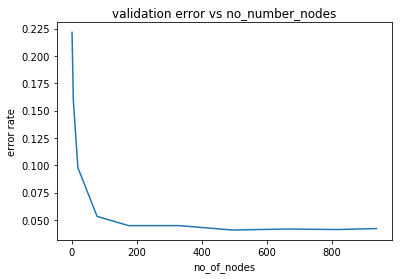

In [18]:
import matplotlib.pyplot as plt
plt.plot(list_num_nodes,list_accuracy_test)
plt.title('validation error vs no_number_nodes')
plt.xlabel('no_of_nodes')
plt.ylabel('error rate')
plt.show()

#### Graph of training error with respect to number of nodes of decision tree.

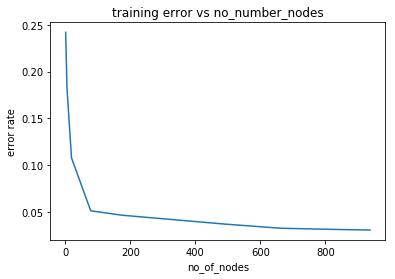

In [19]:
import matplotlib.pyplot as plt
plt.plot(list_num_nodes,list_accuracy_train)
plt.title('training error vs no_number_nodes')
plt.xlabel('no_of_nodes')
plt.ylabel('error rate')
plt.show()